# Train and Predict
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [1]:
# ! pip install zipfile -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 1
import sys
import os
import gc
from time import time
from datetime import timedelta, datetime
import base64
import warnings

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics

sys.path.append('../')
import conf
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
from utils import (
    check_columns,
    check_nan_value,
    correct_column_type,
    load_model,
    plot_dist_of_cols,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# global variables
drop_cols = ['model_type']

In [4]:
# functions
def __dummy():
    pass

### <a id='1'> 1.lightgbm</a>

In [5]:
! du -sh ../data/*

'du' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
# feature engineering
params = {
    'filename':'data_2018_semifinals_all.h5', # file we want to load for feature engineering
    'fe_save_filename':'fe_df_01_01_round_2.feather',  # naming the train fe by the start date of train
    'clip_start_date': '2018-01-01', # start date of data for doing feature engineering e.g. 2018-02-01
    'clip_end_date': '2018-07-31',  # end date of data for doing feature engineering e.g. 2018-06-30
    'use_model_id': None,  # 1,2 and None
    'is_train':True,
    'pred_start_date':None,  # None, 2018-09-01
    'pred_end_date':None,  # None, 2018-09-30
#     'use_retag':False,
#     'num_tag':10,
    'num_processes': 20,
}

fe_df = feature_engineering(**params)

2020-03-28 17:39:30,531 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-03-28 17:39:30,532 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: True，数据集截断起始日期：2018-01-01, 数据集截断结束日期：2018-07-31
2020-03-28 17:39:30,532 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-03-28 17:39:30,533 - mlpipeline.feature_engineering - INFO - 加载数据集: ..\data\data_2018_semifinals_all.h5
2020-03-28 17:41:09,493 - mlpipeline.feature_engineering - INFO - 使用的cols: Index(['smart_1_normalized', 'smart_3_normalized', 'smart_7_normalized', 'smart_184_normalized',
       'smart_9_normalized', 'smart_187_normalized', 'smart_188_normalized',
       'smart_189_normalized', 'smart_191_normalized', 'smart_193_normalized',
       'smart_195_normalized', 'smart_4raw', 'smart_5raw', 'smart_9raw', 'smart_12raw',
       'smart_192raw', 'smart_194raw', 'smart_197raw', 'smart_198raw', 'smart_199raw', 'dt',
       'serial_number', 'model', 'tag', 'flag'],
      dtype='object')
2020-

2020-03-28 17:23:40,169 - mlpipeline.train - INFO - train开始
2020-03-28 17:23:40,170 - mlpipeline.train - INFO - 当前模式:eval on model None, train on model None, 当前使用模型:lgb, 使用cv:False, 训练集日期:2018-04-01 - 2018-05-31, 验证集日期:2018-07-01 - 2018-07-31, 分类阈值: 0.996, 截断个数: 20, 采样：False
2020-03-28 17:24:13,733 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-03-28 17:24:13,761 - mlpipeline.train - INFO - 连续性特征数量: 106
2020-03-28 17:24:13,762 - mlpipeline.train - INFO - 离散性特征数量: 0
2020-03-28 17:24:28,337 - mlpipeline.train - INFO - 训练集正负样本比:193:9111143(i.e. 2e-05)
2020-03-28 17:24:30,419 - mlpipeline.train - INFO - 验证集正负样本比:131:4855601(i.e. 3e-05)
2020-03-28 17:24:31,699 - mlpipeline.train - INFO - eval参数:{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'scale_pos_weight': 40, 'num_leaves': 64, 'metric': ['auc'], 'subsample': 0.8, 'colsample_bytree': 0.7, 'num_threads': 10, 'lambda_l2': 0.5, 'lambda_l1': 0.5, 'random_state': 2019, 'min_data_in_leaf': 80, 'num_boost_round': 10

[1]	training's auc: 0.85181	valid_1's auc: 0.547786
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.883998	valid_1's auc: 0.645708
[3]	training's auc: 0.924396	valid_1's auc: 0.717737
[4]	training's auc: 0.923681	valid_1's auc: 0.76696
[5]	training's auc: 0.930899	valid_1's auc: 0.791855
[6]	training's auc: 0.929815	valid_1's auc: 0.79542
[7]	training's auc: 0.93071	valid_1's auc: 0.795728
[8]	training's auc: 0.931844	valid_1's auc: 0.815269
[9]	training's auc: 0.940081	valid_1's auc: 0.815479
[10]	training's auc: 0.940973	valid_1's auc: 0.820585
[11]	training's auc: 0.941867	valid_1's auc: 0.817438
[12]	training's auc: 0.940917	valid_1's auc: 0.820097
[13]	training's auc: 0.940932	valid_1's auc: 0.820613
[14]	training's auc: 0.938888	valid_1's auc: 0.822326
[15]	training's auc: 0.944492	valid_1's auc: 0.828648
[16]	training's auc: 0.944906	valid_1's auc: 0.825951
[17]	training's auc: 0.945122	valid_1's auc: 0.826848
[18]	training's auc: 0.94633	vali

2020-03-28 17:25:53,368 - mlpipeline.train - INFO - eval最优轮数: 24, eval最优auc: 0.8448932527406522
2020-03-28 17:25:53,369 - mlpipeline.train - INFO - 模型训练用时:0:01:23
2020-03-28 17:25:53,385 - mlpipeline.train - INFO - 特征重要性：            Value                              Feature
32   5.144651e+06                     smart_5raw_std_7
18   3.954067e+06                     err_weight_max_7
103  2.820755e+06                           err_weight
17   9.969946e+05                   smart_199raw_max_7
94   6.884012e+05                 smart_195_normalized
..            ...                                  ...
73   0.000000e+00    smart_4raw_diff_for_last_period_7
46   0.000000e+00          smart_187_normalized_mean_7
78   0.000000e+00  smart_197raw_diff_for_last_period_7
79   0.000000e+00  smart_198raw_diff_for_last_period_7
75   0.000000e+00   smart_12raw_diff_for_last_period_7

[106 rows x 2 columns]


[34]	training's auc: 0.971604	valid_1's auc: 0.838409
Early stopping, best iteration is:
[24]	training's auc: 0.952905	valid_1's auc: 0.844893


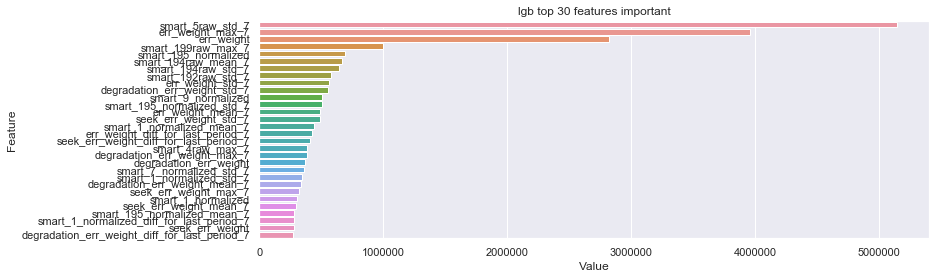

2020-03-28 17:26:02,596 - mlpipeline.train - INFO - 验证日期：2018-07-01 00:00:00
2020-03-28 17:26:03,373 - mlpipeline.train - INFO - 原始预测为fault disk的个数：642
2020-03-28 17:26:03,374 - mlpipeline.train - INFO - 验证日期：2018-07-02 00:00:00
2020-03-28 17:26:04,146 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-03-28 17:26:04,147 - mlpipeline.train - INFO - 验证日期：2018-07-03 00:00:00
2020-03-28 17:26:04,903 - mlpipeline.train - INFO - 原始预测为fault disk的个数：643
2020-03-28 17:26:04,904 - mlpipeline.train - INFO - 验证日期：2018-07-04 00:00:00
2020-03-28 17:26:05,672 - mlpipeline.train - INFO - 原始预测为fault disk的个数：641
2020-03-28 17:26:05,673 - mlpipeline.train - INFO - 验证日期：2018-07-05 00:00:00
2020-03-28 17:26:06,456 - mlpipeline.train - INFO - 原始预测为fault disk的个数：645
2020-03-28 17:26:06,457 - mlpipeline.train - INFO - 验证日期：2018-07-06 00:00:00
2020-03-28 17:26:07,287 - mlpipeline.train - INFO - 原始预测为fault disk的个数：648
2020-03-28 17:26:07,288 - mlpipeline.train - INFO - 验证日期：2018-07-07 00:00:00
2020-03-28 

In [11]:
# eval
model_params = {
    "objective": "binary",
    "boosting": 'gbdt',  # gbdt, dart
    "learning_rate": 0.001,
    "scale_pos_weight":40,
#     "is_unbalance": True,
    "num_leaves": 64,
#     "max_bin":255,
#     'min_gain_to_split': 20,
#     "max_depth":1,
    "metric": ["auc"],
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "num_threads": 10,
    "lambda_l2": 0.5,
    "lambda_l1": 0.5,
    "random_state": 2019,
    "min_data_in_leaf":80,
    "num_boost_round": 1000,
    "device": 'cpu',
#     'boost_from_average':False
}  

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'fe_df_01_01_round_2.feather', #  'sample_1_fe_df_01_01_round_2.feather',
    'is_eval': True,
    "use_standard": False,  # whether using sklearn-standard
    'use_log': False,
    'use_cv': False,  # for cv
    'drop_cols':drop_cols,
    'use_retag': False,
    'num_tag':15,
    'use_sampling': False,
    'sampling_ratio':1,  # downsampling
#     'focal_loss_alpha':0.25,
#     'focal_loss_gamma':2,
    'train_start_date': '2018-04-01',  # when using cv, should be same as the the earliest day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the latest day of cv valid
    'eval_on_model_id': None, # 1,2,None
    'train_on_model_id':None, # 1 ,2 , None
    'save_feat_important': False,
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31',
    'train_date_list':  [['2018-02-01','2018-03-31'],['2018-03-01','2018-04-30']],  # for cv
    'val_date_list': [['2018-05-01','2018-05-31'],['2018-06-01','2018-06-30']],  # for cv
    'n_fold': 2  # for cv 
}

model, eval_df = train(**params)

2020-03-28 17:42:42,458 - mlpipeline.train - INFO - train开始
2020-03-28 17:42:42,460 - mlpipeline.train - INFO - 当前模式:train, 当前使用模型:lgb, 训练日期:2018-06-01 - 2018-07-31
2020-03-28 17:43:21,996 - mlpipeline.train - INFO - train_pipeline_lgb开始
2020-03-28 17:43:22,025 - mlpipeline.train - INFO - 连续性特征数量: 106
2020-03-28 17:43:22,026 - mlpipeline.train - INFO - 离散性特征数量: 0
2020-03-28 17:43:33,357 - mlpipeline.train - INFO - 训练集正负样本比:251:9502915(i.e. 3e-05)
2020-03-28 17:43:33,358 - mlpipeline.train - INFO - train参数:{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.001, 'scale_pos_weight': 40, 'num_leaves': 64, 'metric': ['auc'], 'subsample': 0.8, 'colsample_bytree': 0.7, 'num_threads': 10, 'lambda_l2': 0.5, 'lambda_l1': 0.5, 'random_state': 2019, 'min_data_in_leaf': 80, 'num_boost_round': 24, 'device': 'cpu'}
e:\utility\conda\envs\python3.7\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found

[1]	training's auc: 0.89144
Training until validation scores don't improve for 10 rounds.
[2]	training's auc: 0.889538
[3]	training's auc: 0.888673
[4]	training's auc: 0.888364
[5]	training's auc: 0.887794
[6]	training's auc: 0.906764
[7]	training's auc: 0.907952
[8]	training's auc: 0.909176
[9]	training's auc: 0.91301
[10]	training's auc: 0.913964
[11]	training's auc: 0.917746
[12]	training's auc: 0.925626
[13]	training's auc: 0.9344
[14]	training's auc: 0.935353
[15]	training's auc: 0.948825
[16]	training's auc: 0.952905
[17]	training's auc: 0.95396
[18]	training's auc: 0.954286
[19]	training's auc: 0.95862
[20]	training's auc: 0.956758
[21]	training's auc: 0.964163
[22]	training's auc: 0.965761
[23]	training's auc: 0.968057


2020-03-28 17:44:20,493 - mlpipeline.train - INFO - eval最优轮数: 23, eval最优auc: 0.9680572192973969
2020-03-28 17:44:20,494 - mlpipeline.train - INFO - 模型训练用时:0:00:47


[24]	training's auc: 0.967777
Did not meet early stopping. Best iteration is:
[23]	training's auc: 0.968057


2020-03-28 17:44:21,222 - mlpipeline.train - INFO - 特征重要性：            Value                              Feature
32   1.234866e+07                     smart_5raw_std_7
18   5.827815e+06                     err_weight_max_7
58   2.129550e+06                  smart_198raw_mean_7
31   1.669741e+06                     smart_4raw_std_7
103  1.049181e+06                           err_weight
..            ...                                  ...
80   0.000000e+00  smart_199raw_diff_for_last_period_7
79   0.000000e+00  smart_198raw_diff_for_last_period_7
78   0.000000e+00  smart_197raw_diff_for_last_period_7
75   0.000000e+00   smart_12raw_diff_for_last_period_7
48   0.000000e+00          smart_189_normalized_mean_7

[106 rows x 2 columns]


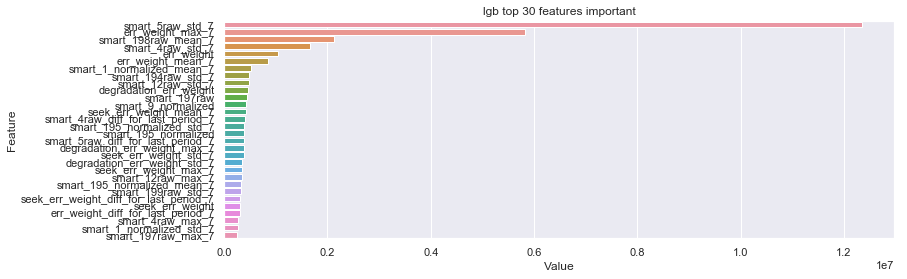

OSError: [Errno 22] Invalid argument: '..\\trained_model\\lgb_2020-03-28T17:43:21.994154.model'

In [6]:
# train
model_params = {
    "objective": "binary",
    "boosting": 'gbdt',  # gbdt, dart
    "learning_rate": 0.001,
    "scale_pos_weight":40,
#     "is_unbalance": True,
    "num_leaves": 64,
#     "max_bin":255,
#     'min_gain_to_split': 20,
#     "max_depth":1,
    "metric": ["auc"],
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "num_threads": 10,
    "lambda_l2": 0.5,
    "lambda_l1": 0.5,
    "random_state": 2019,
    "min_data_in_leaf":80,
    "num_boost_round": 24,
    "device": 'cpu',
#     'boost_from_average':False
}  

params = {
    'model_params': model_params,
    'model_name': 'lgb',
    'fe_filename': 'fe_df_01_01_round_2.feather',
#     'focal_loss_alpha':0.9,
#     'focal_loss_gamma':6,
    'use_sampling': False,
    'sampling_ratio':2,
    'drop_cols': drop_cols,
    'train_on_model_id':None,
    'is_eval': False,
    'use_standard': False,
    'use_log': False,
    'save_feat_important': False,
    'train_start_date': '2018-06-01',
    'train_end_date': '2018-07-31',
}

model, scaler = train(**params)

In [ ]:
# predict 
params = {'model_name': 'lgb',
          'use_standard': False,
          'use_log': False,
          'scaler':'',
            }

submission_df = predict(**params)